In [1]:
import numpy as np
import pandas as pd
import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.express as px
from datetime import datetime,date

%matplotlib inline
init_notebook_mode(connected=True)
cf.set_config_file(sharing='private',theme='pearl',offline=True)
#print("Cufflinks Version : {}".format(cf.__version__))

df = pd.read_csv('./data/eth-usd-max latest.csv',index_col=0,parse_dates=True )
df.drop(["market_cap", "total_volume"], axis=1, inplace=True)
df = df.resample('D').first()
df['price'].fillna(method='ffill', inplace=True)
# to get the log price
# df['price'] = np.log(df['price'])

C:\Users\sagap\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)



In [2]:
def first_day(entry):
    """
    Returns the first instance of the period, regardless of sampling rate.
    """
    if len(entry):  # handles the case of missing data
        return entry[0]

In [3]:
# here i will use monthly data
df= df.resample(rule='MS').apply(first_day)

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

<AxesSubplot:xlabel='snapped_at'>

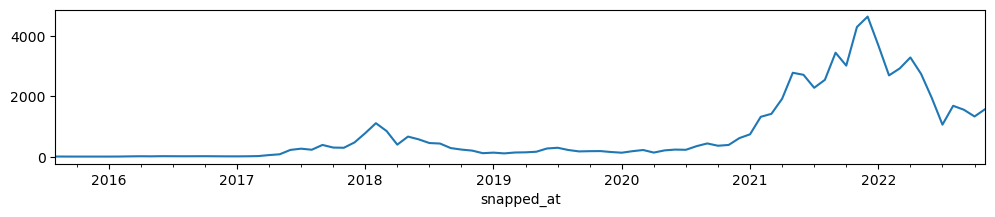

In [5]:
results = seasonal_decompose(df['price'])
results.observed.plot(figsize=(12,2))

<AxesSubplot:xlabel='snapped_at'>

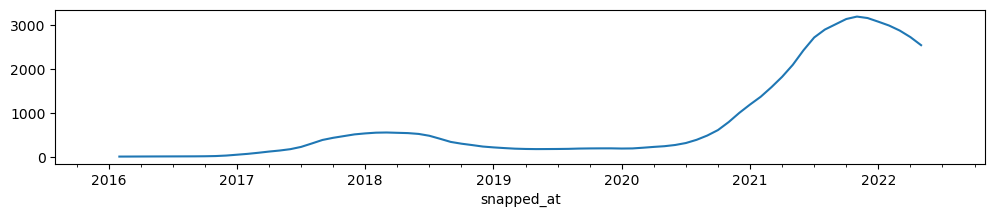

In [6]:
results.trend.plot(figsize=(12,2))

<AxesSubplot:xlabel='snapped_at'>

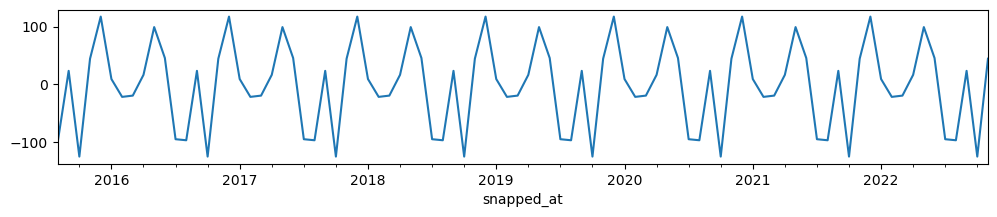

In [7]:
results.seasonal.plot(figsize=(12,2))

In [8]:
len(df)

88

In [9]:
train = df

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [12]:
# we do this just on the training data as in real life we have no idea of the actual datra to fit for the test set
scaler.fit(train) # finds the max value in the training set

MinMaxScaler()

In [13]:
# transform the training and test data via the scaler object above. MinMaxscaler doesnt simply divide 
# by athe max or min value... it uses more complex method
scaled_train = scaler.transform(train)

In [14]:
# now everything is scaled we need to createa timeseries generator to feed the neural network
from keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
# Redefine to get 70 last days back and then predict the nextday out
n_input =45 # using this number so as to catch the 60 day cyclicality
n_features = 1 # for time series it is 1 as we have one output the prediction (one column of data)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [16]:
# Create the model , train it and test it
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [17]:
## define model
#model = Sequential()
## 100 is the number of neurons. we play around to find a good number and you play around
#model.add(LSTM(500, activation='relu', input_shape=(n_input, n_features)))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mse')

In [18]:
# define model 2
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 45, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 45, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [20]:
# 1 epoch is a single run through all our data
model.fit(generator,epochs=10)

Epoch 1/10
43/43 [==============================] - 7s 52ms/step - loss: 0.0842
Epoch 2/10
43/43 [==============================] - 2s 43ms/step - loss: 0.0515
Epoch 3/10
43/43 [==============================] - 2s 40ms/step - loss: 0.0599
Epoch 4/10
43/43 [==============================] - 2s 41ms/step - loss: 0.0403
Epoch 5/10
43/43 [==============================] - 2s 49ms/step - loss: 0.0288
Epoch 6/10
43/43 [==============================] - 2s 39ms/step - loss: 0.0283
Epoch 7/10
43/43 [==============================] - 1s 33ms/step - loss: 0.0221
Epoch 8/10
43/43 [==============================] - 2s 42ms/step - loss: 0.0193
Epoch 9/10
43/43 [==============================] - 2s 42ms/step - loss: 0.0177
Epoch 10/10
43/43 [==============================] - 2s 48ms/step - loss: 0.0142


In [21]:
model.history.history.keys()

dict_keys(['loss'])

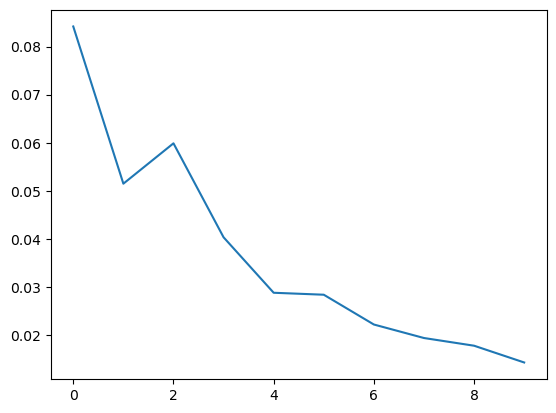

In [22]:
import matplotlib.pyplot as plt
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [23]:
# our model takes the last 12 history steps and predicts the next one 
first_eval_batch = scaled_train[-45:]

In [24]:
# in order to actually forecast into the future
test_predictions = [] # holding the predictions as we go along

# Last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
# we use the predicted points to predict further and further into the future 
# so RNN cannot work very well far into the future
# in order to predict into the future we can change the range for example len(test)+6 to forecast another 6 months
# or we can use the actual df2 to train and freely forecast into the future!
for i in range(48):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 40ms/step


In [25]:
# Inverse Transformations and Compare
true_predictions = scaler.inverse_transform(test_predictions)

In [26]:
true_predictions

array([[1253.24218545],
       [1172.93010298],
       [1121.24550818],
       [1093.71756045],
       [1090.34467075],
       [1112.72795992],
       [1160.64855628],
       [1236.79903728],
       [1340.84985182],
       [1471.90837936],
       [1629.48464585],
       [1812.68547804],
       [2019.9762871 ],
       [2250.47191403],
       [2501.84919642],
       [2771.46758031],
       [3055.42482162],
       [3347.1605739 ],
       [3639.38243129],
       [3922.42964181],
       [4184.79734918],
       [4413.05562134],
       [4590.91427157],
       [4701.29136148],
       [4728.06389799],
       [4662.49414849],
       [4507.30142757],
       [4272.2343675 ],
       [3981.1093556 ],
       [3660.13710249],
       [3332.1844462 ],
       [3015.55950386],
       [2722.75343599],
       [2460.45260608],
       [2235.51789459],
       [2046.70073817],
       [1889.93390993],
       [1762.72111225],
       [1663.82207237],
       [1592.43688622],
       [1547.47409718],
       [1527.530

In [27]:
# to add an extra period
#predictionsIndex = pd.date_range(pd.to_datetime(df.index[len(df)-1])+pd.DateOffset(months=1), periods=48, freq='M')
predictionsIndex = pd.date_range(pd.to_datetime(df.index[len(df)-1])+pd.DateOffset(months=1), periods=48, freq='MS')
#predictionsIndex = pd.date_range(pd.to_datetime(df.index[len(df)-1]), periods=120, freq='d')
predictions = pd.DataFrame(true_predictions,index=predictionsIndex, columns=['Prediction'])
predictions

,Prediction
2022-12-01 00:00:00+00:00,1253.242185
2023-01-01 00:00:00+00:00,1172.930103
2023-02-01 00:00:00+00:00,1121.245508
2023-03-01 00:00:00+00:00,1093.717560
2023-04-01 00:00:00+00:00,1090.344671
2023-05-01 00:00:00+00:00,1112.727960
2023-06-01 00:00:00+00:00,1160.648556
2023-07-01 00:00:00+00:00,1236.799037
2023-08-01 00:00:00+00:00,1340.849852
2023-09-01 00:00:00+00:00,1471.908379


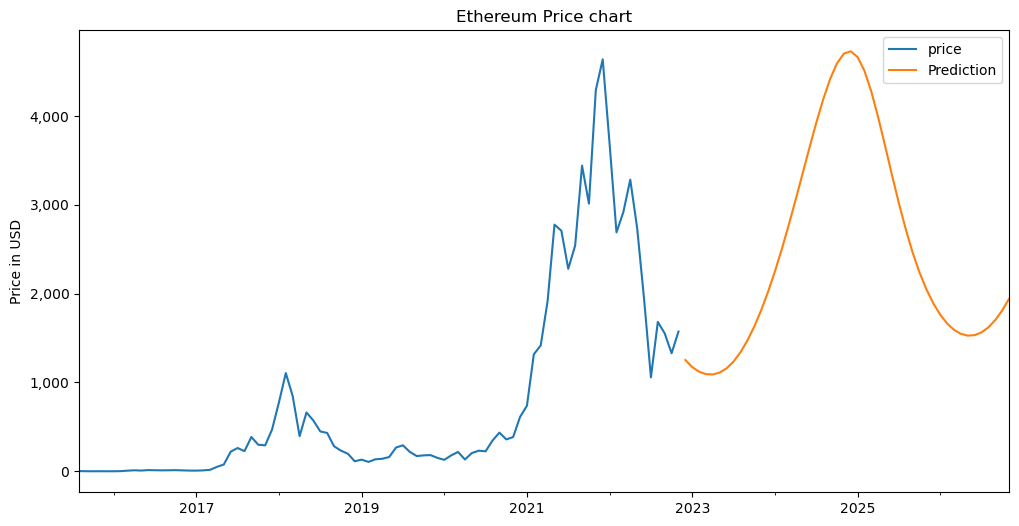

In [28]:
# Plot predictions against known values
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')
title = 'Ethereum Price chart'
ylabel='Price in USD'
xlabel='' # we don't really need a label here

ax = df['price'].plot(legend=True,figsize=(12,6),title=title)
predictions['Prediction'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [29]:
# same plot as above but with plotly
result = df.join(predictions['Prediction'], how='outer')
result[['price','Prediction']].iplot()

In [30]:
# in order not to retrain every time we can save the model
model.save('ETH_rnn_daily_model.h5')

In [31]:
# and in order to reload 
# from keras.models import load_model
# model = load_model('BTC_rnn_model.h5')
# model.summary()